## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Camera calibration via chessboard images. 

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

#images=os.listdir('camera_cal')
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        ''' Commenting this section to stop slowing code execution during dev work. 
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()'''
print('Object and Image points collected')

Object and Image points collected


#### Using the object points and image points, undistort a calibration image and check the output

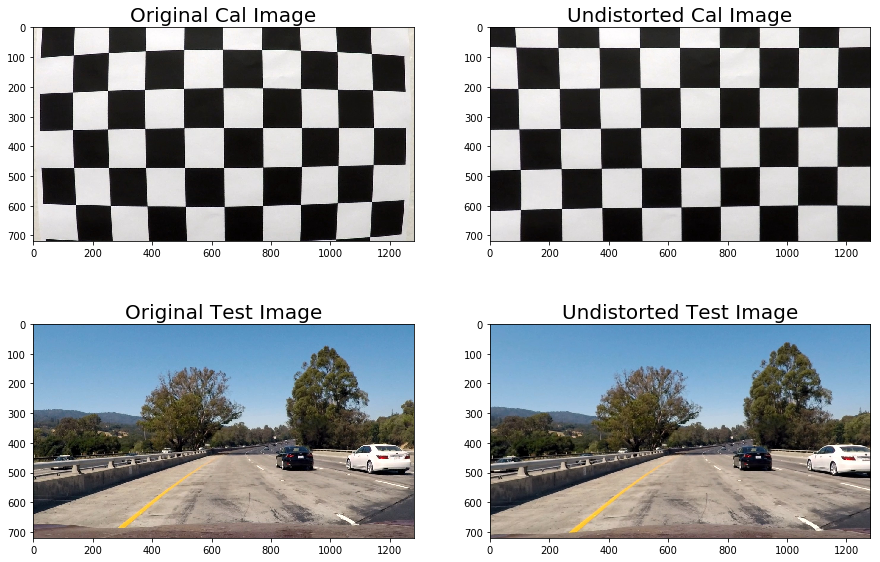

In [8]:
## Create camera calibration matrices using object and image points. 

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
## Verify capability of test matrix. 
calimg=mpimg.imread(images[0])
cal_undst = cv2.undistort(calimg, mtx, dist, None, mtx)
testimg=mpimg.imread('./test_images/test1.jpg')
test_undst = cv2.undistort(testimg, mtx, dist, None, mtx)


## Switch to inline plotting

%matplotlib inline

f1, ax1 = plt.subplots(2, 2,figsize=(15,10));
ax1[0,0].imshow(calimg)
ax1[0,0].set_title('Original Cal Image',fontsize=20);
ax1[0,1].imshow(cal_undst)
ax1[0,1].set_title('Undistorted Cal Image',fontsize=20);
ax1[1,0].imshow(testimg)
ax1[1,0].set_title('Original Test Image',fontsize=20);
ax1[1,1].imshow(test_undst)
ax1[1,1].set_title('Undistorted Test Image',fontsize=20);


This appears to work as expected.  On to thresholding. 

### Step 2. Colorspace and gradient exploration.

For this I intend to use all of the test images but first I will define each function individually and test on a single test image to verify function. 

In previous projects and lessons, the YUV and LAB colorspaces showed strenghts in identifying features. I am going to create helper functions for that as well. The HLS mentioned in this lesson is included as well. 

I am going to build smaller individual functions to observe their effects and then use this library of small functions to construct the pipeline with each step being easily observable if required. 

In [25]:
def yuv_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, channelIndex]
    return tgt_channel

def lab_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:, :, channelIndex]
    return tgt_channel

def hsv_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:, :, channelIndex]
    return tgt_channel

def hls_chn(img,channelIndex):
    tgt_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, channelIndex]
    return tgt_channel

def rgb_chn(img,channelIndex):
    tgt_channel = img[:, :, channelIndex]
    return tgt_channel

def plot_test_group(imgfunc,labellist,testset):
    f,ax=plt.subplots(len(testset),4,figsize=(17,20))
    for j in range(len(testset)):
        test_img=mpimg.imread(testset[j])
        ax[j,0].imshow(imgfunc(test_img,0),cmap='gray')
        ax[j,0].set_title(labellist[0])
        ax[j,0].axis('off')
        ax[j,1].imshow(imgfunc(test_img,1),cmap='gray')
        ax[j,1].set_title(labellist[1])
        ax[j,1].axis('off')
        ax[j,2].imshow(imgfunc(test_img,2),cmap='gray')
        ax[j,2].set_title(labellist[2])
        ax[j,2].axis('off')
        ax[j,3].imshow(test_img)
        ax[j,3].set_title('Original')
        ax[j,3].axis('off')
    f.subplots_adjust(wspace=0, hspace=0)

testset=glob.glob('./test_images/test*.jpg')

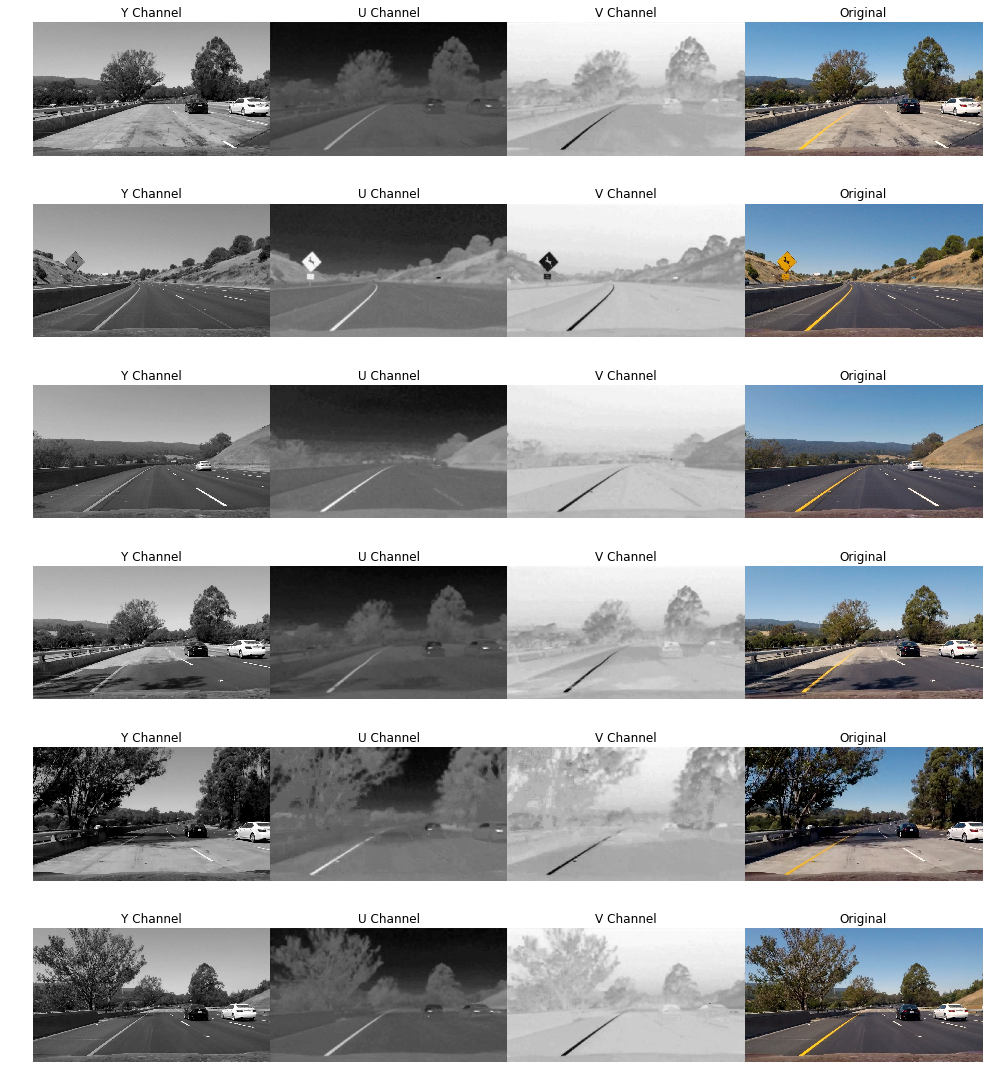

In [26]:
yuvlabels=['Y Channel','U Channel','V Channel']
plot_test_group(yuv_chn,yuvlabels,testset)

## WRITE THOUGHTS ON YUV RESULTS

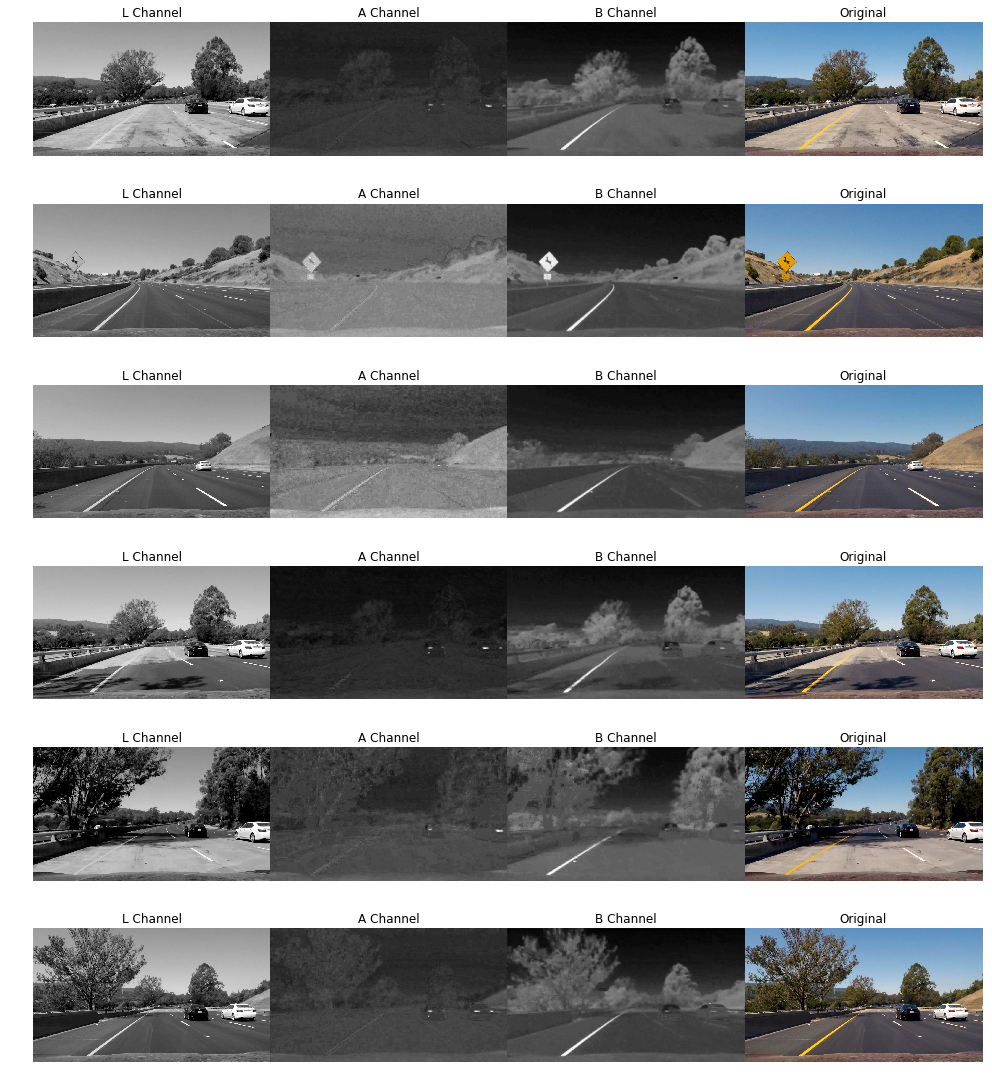

In [27]:
lablabels=['L Channel','A Channel','B Channel']
plot_test_group(lab_chn,lablabels,testset)

## WRITE THOUGHTS ON LAB RESULTS

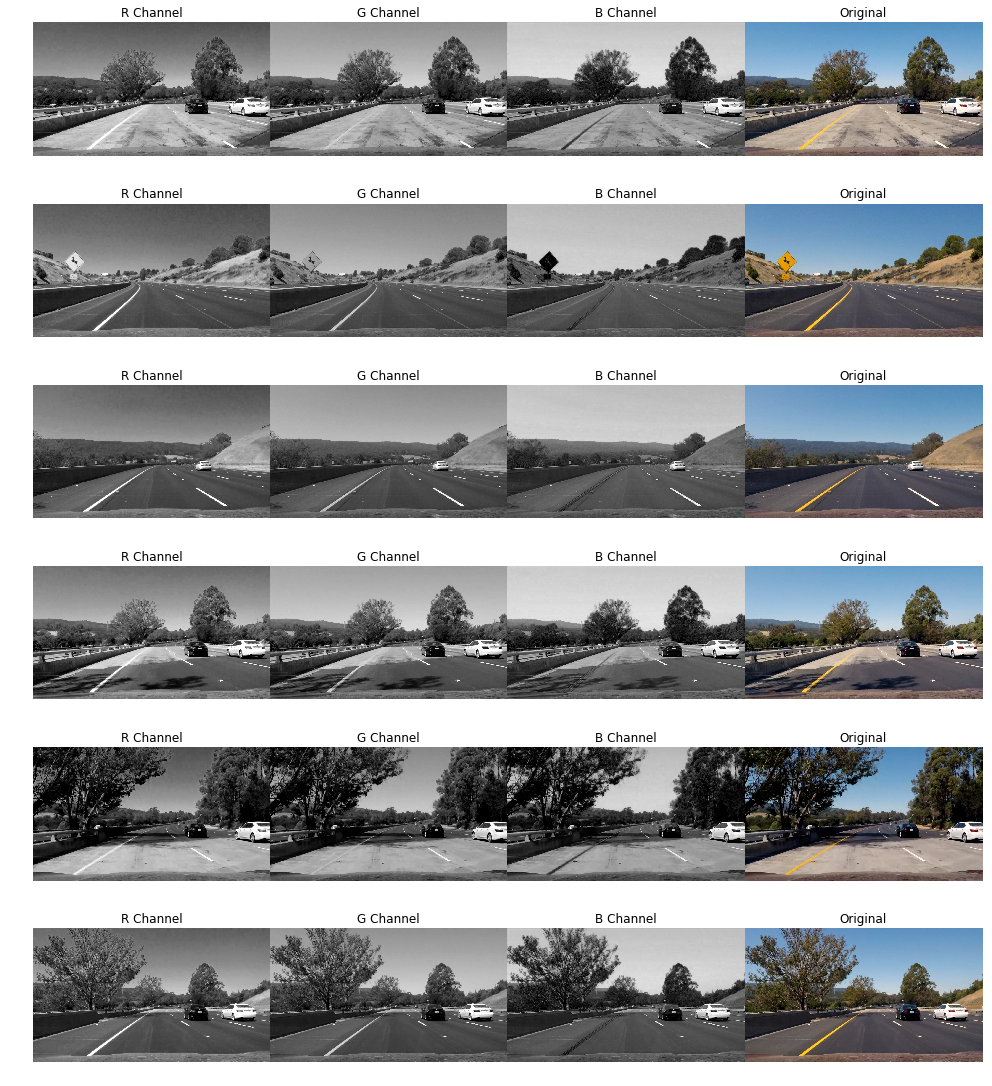

In [28]:
rgblabels=['R Channel','G Channel','B Channel']
plot_test_group(rgb_chn,rgblabels,testset)

## WRITE THOUGHTS ON RGB RESULTS

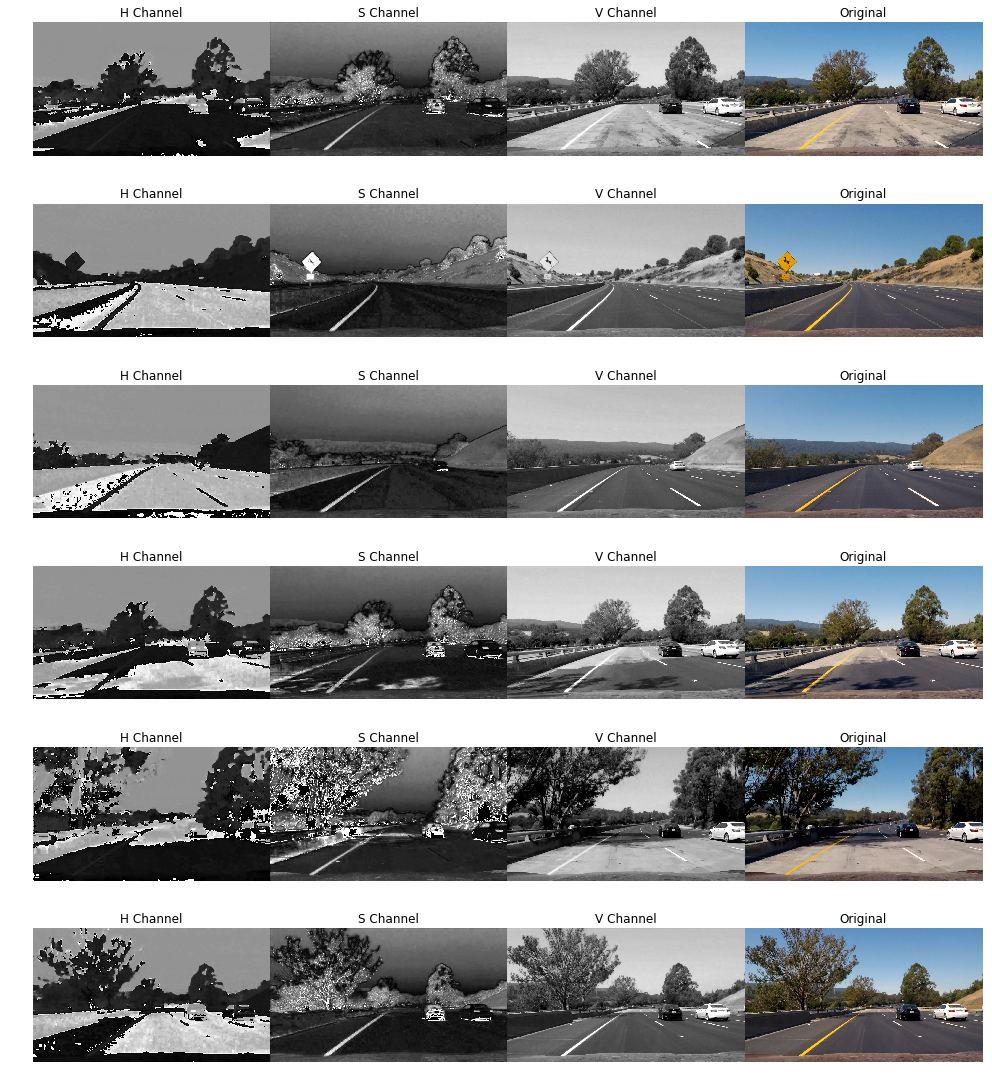

In [29]:
hsvlabels=['H Channel','S Channel','V Channel']
plot_test_group(hsv_chn,hsvlabels,testset)

## WRITE THOUGHTS ON HSV RESULTS

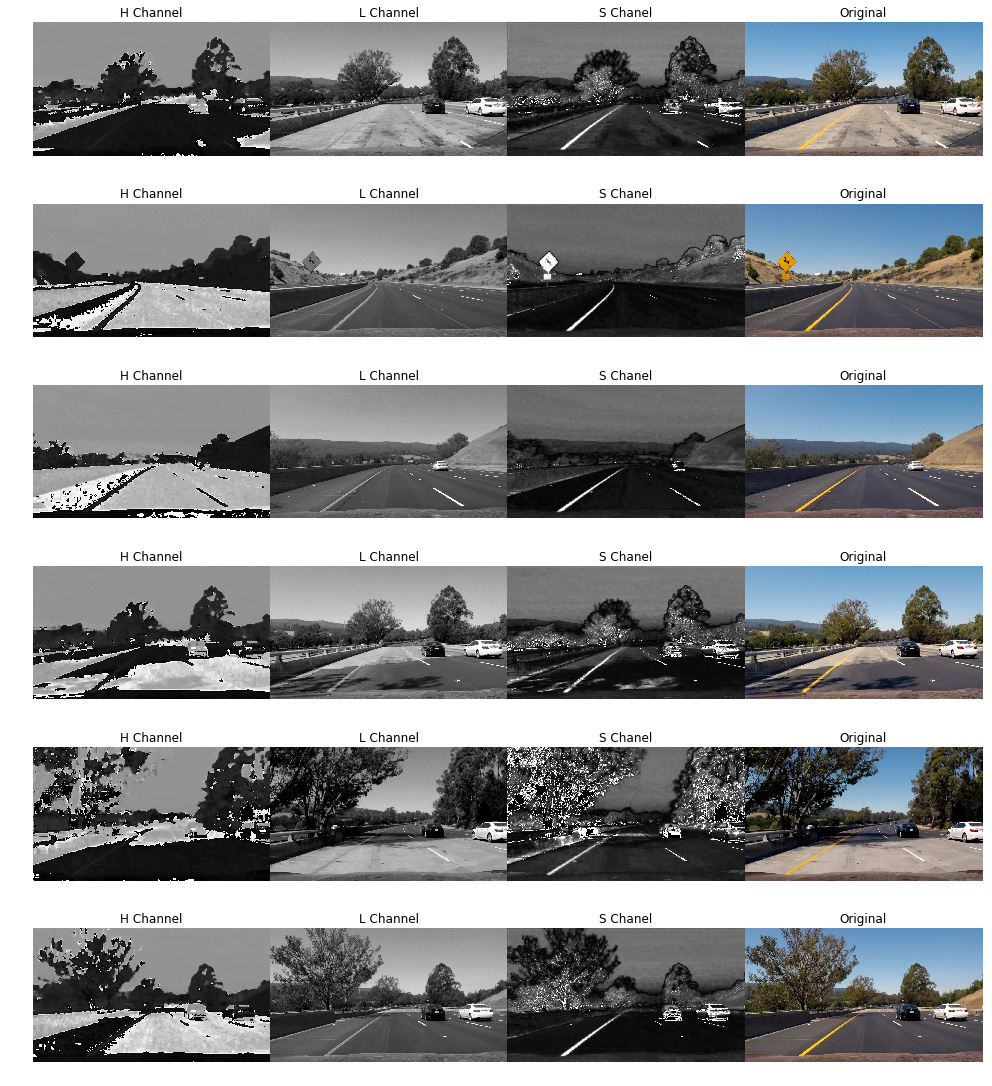

In [30]:
hlslabels=['H Channel','L Channel','S Chanel']
plot_test_group(hls_chn,hlslabels,testset)

## Gradient function development 

In order to find more generalized edges in the image, sobel gradients in the x and y direction will be used. 
As done in the lesson, I will test this on S channel image from HLS colorspace. 

In [38]:
## define the sobels in x and y
def sobelx(sngl_chn_img):
    abs_sobel=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    return scaled_sobel

def sobely(sngl_chn_img):
    abs_sobel=np.abs(cv2.Sobel(sngl_chn_img, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    return scaled_sobel

## define the gradient magnitude
def gradmag(sngl_chn_img):
    gradmagflt=np.sqrt(np.power(sobelx(sngl_chn_img),2)+np.power(sobely(sngl_chn_img),2))
    scaled_gradmag = np.uint8(255 * gradmagflt / np.max(gradmagflt))
    return scaled_gradmag

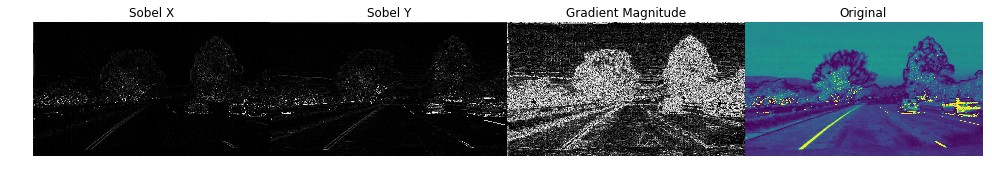

In [39]:
labellist=['Sobel X', 'Sobel Y','Gradient Magnitude']
f,ax=plt.subplots(1,4,figsize=(17,20))
test_img=hls_chn(mpimg.imread(testset[0]),2)

ax[0].imshow(sobelx(test_img),cmap='gray')
ax[0].set_title(labellist[0])
ax[0].axis('off')
ax[1].imshow(sobely(test_img),cmap='gray')
ax[1].set_title(labellist[1])
ax[1].axis('off')
ax[2].imshow(gradmag(test_img),cmap='gray')
ax[2].set_title(labellist[2])
ax[2].axis('off')
ax[3].imshow(test_img)
ax[3].set_title('Original')
ax[3].axis('off')
f.subplots_adjust(wspace=0, hspace=0)

## Defining a threshold function for producing binary images. 

In [40]:
def aplythrsh(sngl_chn_img,thresh=(0,255)):
    bin_out=np.zeros_like(sngl_chn_img)
    bin_out[(sngl_chn_img >= thresh[0]) & (sngl_chn_img <= thresh[1])] = 1
    return bin_out

## Creating the perspective matrix to generate a birds eye view. 

## VERIFY TRANSFORM PROCESS

## RE-USE ORIGINAL LANE FINDING METHODOLOGY FOR FINDING POINTS

In order to create the perspective matrix, I need to define the 4 corners of the image in its original and warped state. Provided in the project is a pair of images with straight, clean lane lines for this purpose. While I could manually pick these end points, I have done something similar with good deal of accuracy in the first project of the term. Inside of that image pipeline, the endpoints of the lane lines were defined in the visible region bounded by the mask chosen to remove the horizon and the car hood. This is the same region being defined here so re-using that framework is advantageous. 

The function below is a modified version of that code. Instead of outputting an image, two numpy arrays are provided. 
1) 4 points defining the locations of the lane endpoints within the mask as found by the image pipeline. 
2) 2 original lower points and 2 upper points with the same lateral location and the vertical location representing the top of the image. 